# Projet P6 - Classifiez automatiquement des biens de consommation
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 05/2024*
<hr>

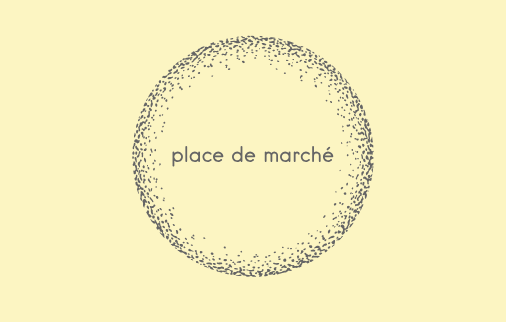

## <font color='#46abe6'>Contexte</font>

Sur place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
 
Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.
 
La mission est de réaliser une étude de faisabilité d'un moteur de classification automatique d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible. 

Le présent notebook porte sur l'extraction des features texte. Les différents types d'approches à tester sont : 
- bag-of-words, comptage simple de mots et Tf-idf
- word/sentence embedding classique avec Word2Vec
- word/sentence embedding avec BERT
- word/sentence embedding avec USE (Universal Sentence Encoder)

## <font color='#46abe6'>Sommaire</font>

<span style='background:#46abe6'><span style='color:white'>**Partie 1 - Données textuelles - Analyse exploratoire des données**</span></span>

<span style='background:#d5155b'><span style='color:white'>**Partie 2 - Données textuelles - Feature extraction et faisabilité**</span></span>

[Etude de faisabilité de la classification à partir des données textuelles](#1) 
* [Importation librairies + fonctions + données](#1_1)
* [Bag-of-words et Tf-idf](#1_2)
* [Word2Vec](#1_3)
* [BERT](#1_4)
* [USE (Universal Sentence Encoder)](#1_5)

[Conclusion & Perspectives](#conclusion)


<span style='background:#46abe6'><span style='color:white'>**Partie 3 - Images - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 4 - Images - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 5 - Images - Classification**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 6 - Images - Requête API**</span></span>

# <font color='#0a389f'> Partie 2 - Etude de faisablité classification à partir des données textuelles<a class="anchor" id="1"></a></font>

## <font color='#46abe6'>Importation librairies + fonctions + données<a class="anchor" id="1_1"></a></font>

### Librairies

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

import time
from IPython.display import Markdown # affichage Markdown des Outputs
import pickle

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

# Bag-of-words, Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Word2vec
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, GlobalAveragePooling1D

In [2]:
!pip list

Package                           Version
--------------------------------- ---------------
absl-py                           2.1.0
adjustText                        0.8
aiobotocore                       2.4.2
aiofiles                          22.1.0
aiohttp                           3.8.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.0
anaconda-navigator                2.4.2
anaconda-project                  0.11.1
anyio                             3.5.0
appdirs                           1.4.4
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.1
asttokens                         2.0.5
astunparse                        1.6.3
async-timeout           


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.4
pandas - 2.2.2
seaborn - 0.13.2
gensim - 4.3.0


In [41]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=10)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=10)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

### Fonctions

#### Classification, évaluation et réprésentation graphique

In [5]:
# Importez le script des fonctions
from LeRay_Adeline_7_Fonctions_communes_052024 import *

#### Bag-of-Words

In [6]:
# Création de représentations BoW et TF-IDF
def bow_TfIdf_vectorization(df_final, tokens_col, method='bow', max_df=0.95, min_df=1):
    """
    @brief Création de représentations BoW et Tf-Idf

    @param df_final: DataFrame contenant les données textuelles.
    @param tokens_col: Nom de la colonne contenant les tokens (str).
    @param method: Méthode de vectorisation ('bow' pour Bag of Words, 'tf-idf' pour Tf-Idf) (str).
    @param max_df : Si float, limite de fréquence du token dans le document au-dessus de la laquelle le token est ignoré.
                    Si int, limite de fréquence du token dans les documents au-dessus de la laquelle le token est ignoré.
    @parma min_df : Si float, limite de fréquence du token dans le document en-dessous de la laquelle le token est ignoré.
                    Si int, limite de fréquence du token dans les documents en-dessous de la laquelle le token est ignoré.
    @return transform : Représentation BoW ou Tf-Idf
    """    
    # Création des représentations en bag-of-words (BoW)
    df_final['sentence_bow'] = [' '.join(tokens) for tokens in df_final[tokens_col]]
    
    # Vectorisation BoW et TF-IDF
    if method == 'bow':
        vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
    elif method == 'tf-idf':
        vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df)
    else:
        raise ValueError("La méthode doit être 'bow' ou 'tf-idf'")
    
    transform = vectorizer.fit_transform(df_final['sentence_bow'])
    
    return transform

#### Word Embedding

In [7]:
def train_word2vec(sentences, w2v_size=300, w2v_window=5, w2v_min_count=1, w2v_epochs=100):
    """
    @brief Entraîne un modèle Word2Vec sur les phrases données.

    @param sentences: Les phrases à utiliser pour l'entraînement (list).
    @param w2v_size: La dimension des vecteurs de mots (int, default=300).
    @param w2v_window: La taille de la fenêtre contextuelle (int, default=5).
    @param w2v_min_count: Le nombre minimum d'occurrences requises pour un mot (int, default=1).
    @param w2v_epochs: Le nombre d'itérations sur les données (int, default=100).

    @return w2v_model: Le modèle Word2Vec entraîné.
    @return model_vectors: Les vecteurs de mots du modèle.
    @return w2v_words: Les mots du vocabulaire du modèle.
    """
    # Affichage du message de progression
    print("Build & train Word2Vec model ...")
    # Entraînement du modèle Word2Vec
    w2v_model = gensim.models.Word2Vec(sentences=sentences, 
                                       vector_size=w2v_size, 
                                       window=w2v_window, 
                                       min_count=w2v_min_count, 
                                       seed=42, 
                                       workers=4)
    # Entraînement sur les données
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    # Récupération des vecteurs de mots et du vocabulaire
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    # Affichage de la taille du vocabulaire
    print("Vocabulary size: %i" % len(w2v_words))
    # Affichage de la fin de l'entraînement
    print("Word2Vec trained")

    return w2v_model, model_vectors, w2v_words

def prepare_input_data(sentences, maxlen):
    """
    @brief Prépare les données d'entrée pour l'entraînement du modèle d'embedding.

    @param sentences: Les phrases tokenisées (list).
    @param maxlen: La longueur maximale des phrases (int).

    @return word_index: Le dictionnaire de vocabulaire.
    @return x_sentences: Les phrases tokenisées et paddées.
    """
    # Création du dictionnaire de vocabulaire
    word_index = {}
    index = 1  # L'indexation commence à 1
    for sentence in sentences:
        for word in sentence:
            if word not in word_index:
                word_index[word] = index
                index += 1

    # Conversion des phrases en séquences d'entiers
    sequences = [[word_index[word] for word in sentence] for sentence in sentences]

    # Padding des séquences
    x_sentences = pad_sequences(sequences, maxlen=maxlen, padding='post')

    # Calcul du nombre de mots uniques
    num_words = len(word_index) + 1
    print("Number of unique words: %i" % num_words)

    return word_index, x_sentences

def create_embedding_matrix(word_index, w2v_words, model_vectors, w2v_size):
    """
    @brief Crée la matrice d'embedding pour le modèle.

    @param word_index: Le dictionnaire de vocabulaire.
    @param w2v_words: Les mots du vocabulaire du modèle Word2Vec (list).
    @param model_vectors: Les vecteurs de mots du modèle Word2Vec (gensim.models.keyedvectors.KeyedVectors).
    @param w2v_size: La taille des vecteurs Word2Vec.

    @return embedding_matrix: La matrice d'embedding pour le modèle (numpy.ndarray).
    """
    # Création de la matrice d'embedding
    print("Create Embedding matrix ...")
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))

    i = 0
    j = 0

    # Parcours de tous les mots du dictionnaire de vocabulaire
    for word, idx in word_index.items():
        i += 1
        # Vérification si le mot est dans le vocabulaire Word2Vec
        if word in w2v_words:
            j += 1
            # Récupération du vecteur de mot correspondant
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                # Affectation du vecteur dans la matrice d'embedding
                embedding_matrix[idx] = embedding_vector

    # Calcul du taux d'embedding
    word_rate = np.round(j/i, 4)
    print("Word embedding rate: ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))

    return embedding_matrix

def build_embedding_model(maxlen, vocab_size, w2v_size, embedding_matrix):
    """
    @brief Construit le modèle d'embedding.

    @param maxlen: La longueur maximale des phrases (int).
    @param vocab_size: La taille du vocabulaire (int).
    @param w2v_size: La taille des vecteurs Word2Vec.
    @param embedding_matrix: La matrice d'embedding (numpy.ndarray).

    @return embed_model: Le modèle d'embedding construit (keras.engine.functional.Functional).
    """
    # Affichage du message de progression
    print("Create embedding model ...")
    # Définition de l'entrée du modèle
    input = Input(shape=(maxlen,), dtype='int32')
    # Création de la couche d'embedding avec la matrice prédéfinie
    word_embedding = Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix])(input)
    # Création de la couche de moyenne globale
    word_vec = GlobalAveragePooling1D()(word_embedding)

    # Création du modèle
    embed_model = Model(inputs=[input], outputs=[word_vec])
    # Affichage de la structure du modèle
    embed_model.summary()

    return embed_model

def train_word_embedding(df, maxlen_percentile=90):
    """
    @brief Entraîne un modèle d'embedding.

    @param df: Le DataFrame contenant les données (pandas.DataFrame).
    @param maxlen_percentile: Le percentile à utiliser pour déterminer la longueur maximale des phrases (float, default=90).

    @return embeddings: Les embeddings des phrases (numpy.ndarray).
    """
    # Récupération des phrases à partir du DataFrame
    sentences = df['tokens_desc'].tolist()
    # Calcul de la longueur maximale des phrases
    maxlen = int(np.percentile([len(desc) for desc in sentences], maxlen_percentile))
    # Entraînement du modèle Word2Vec
    w2v_size=300
    w2v_model, model_vectors, w2v_words = train_word2vec(sentences, 
                                                         w2v_size=w2v_size, 
                                                         w2v_window=5, 
                                                         w2v_min_count=1, 
                                                         w2v_epochs=100)
    # Préparation des données d'entrée
    word_index, x_sentences = prepare_input_data(sentences, maxlen)
    # Création de la matrice d'embedding
    embedding_matrix = create_embedding_matrix(word_index, w2v_words, model_vectors, w2v_size)
    # Calcul de la taille du vocabulaire
    vocab_size = len(word_index) + 1
    # Construction du modèle d'embedding
    embed_model = build_embedding_model(maxlen, vocab_size, w2v_size, embedding_matrix)
    
    # Prédiction des embeddings des phrases
    return embed_model.predict(x_sentences)

### Données

In [8]:
# Importation des données
df_final = pd.read_pickle('df_final.pkl')

In [9]:
# Extraction des catégories et conversion en indices numériques
l_cat = list(set(df_final['main_category']))
y_cat_num = [(l_cat.index(df_final.iloc[i]['main_category'])) for i in range(len(df_final))]

In [10]:
# Initialisation d'une liste pour stocker les tableaux y_subcat_num par catégorie
y_subcat_num_by_category = []

# Parcours de chaque catégorie
for main_category in l_cat:
    # Filtrage du DataFrame pour les produits appartenant à la catégorie 
    df_main_category = df_final[df_final['main_category'] == main_category]
    # Extraction des sous-catégories uniques pour cette catégorie
    subcategories = list(set(df_main_category['sub_category']))
    # Création d'un tableau y_subcat_num pour cette catégorie
    y_subcat_num = [subcategories.index(subcat) for subcat in df_main_category['sub_category']]
    # Ajout du tableau y_subcat_num à la liste
    y_subcat_num_by_category.append(np.array(y_subcat_num))

In [11]:
subcategories_by_category = []

for main_category in l_cat:
    # Filtrage du DataFrame pour les produits appartenant à la catégorie principale actuelle
    df_main_category = df_final[df_final['main_category'] == main_category]
    # Extraction des sous-catégories uniques pour cette catégorie principale
    subcategories = list(set(df_main_category['sub_category']))
    # Ajout des sous-catégories à la liste
    subcategories_by_category.append(subcategories)

In [12]:
# initialisation de eval_df
eval_df = pd.DataFrame()

## <font color='#46abe6'>Bag-of-words<a class="anchor" id="1_2"></a></font>

### Bag-of-words

* **Création de représentations BoW**

In [13]:
# Création de représentations BoW
cv_transform = bow_TfIdf_vectorization(df_final, 'tokens_desc', method='bow', max_df=0.95, min_df=1)

* **Classifcation et analyse des résultats**

**CountVectorizer - bag-of-words:** 

ARI :  0.4033 time :  10.0


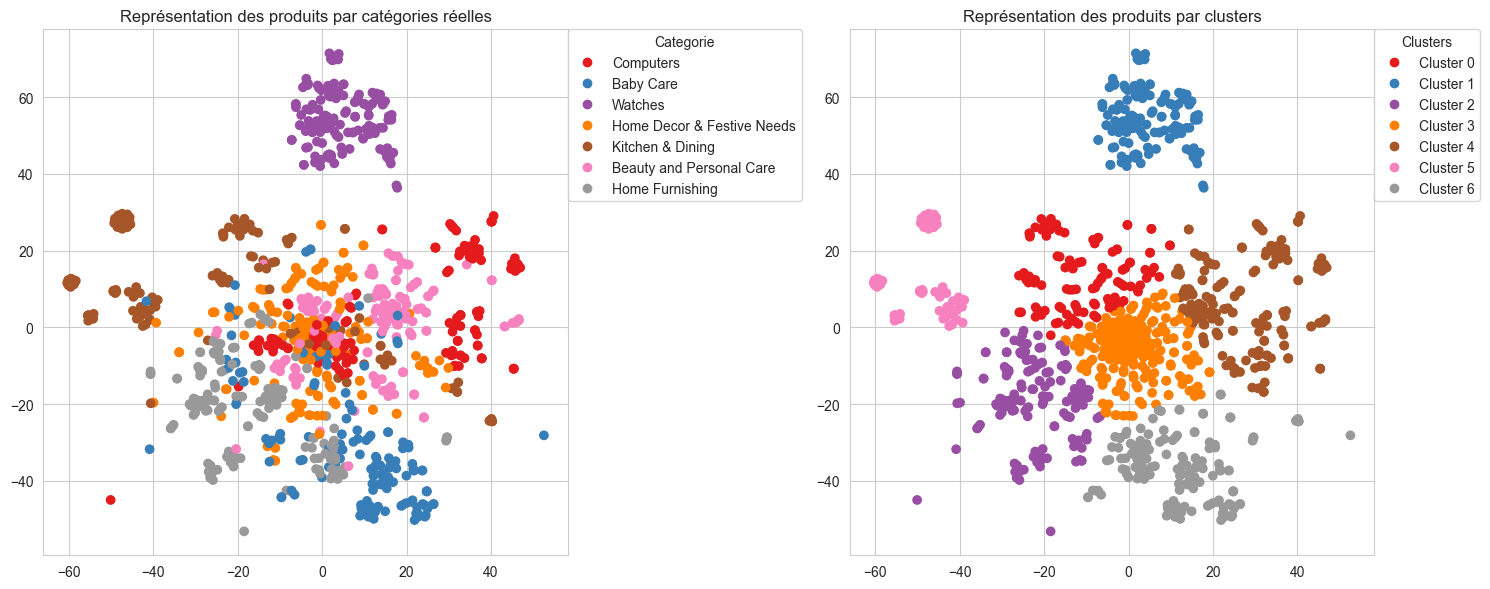

In [14]:
# Calcul de similarité Adjusted Rand Index (ARI) et visualisation du t-SNE selon les vraies catégories et selon les clusters
display(Markdown("**CountVectorizer - bag-of-words:** "))
ARI, X_tsne, labels =   ARI_fct(cv_transform, 
                                l_cat, 
                                y_cat_num, 
                                perplexity=20, 
                                init_tsne='random',
                                max_iter=1000, 
                                learning_rate=200, 
                                n_init=10, 
                                init_kmeans='k-means++',
                                random_state=42)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat, figsize=(15, 6), cmap='Set1')

La catégorie 'Watches' est la seule qui est bien classifiée automatiquement avec cette méthode.

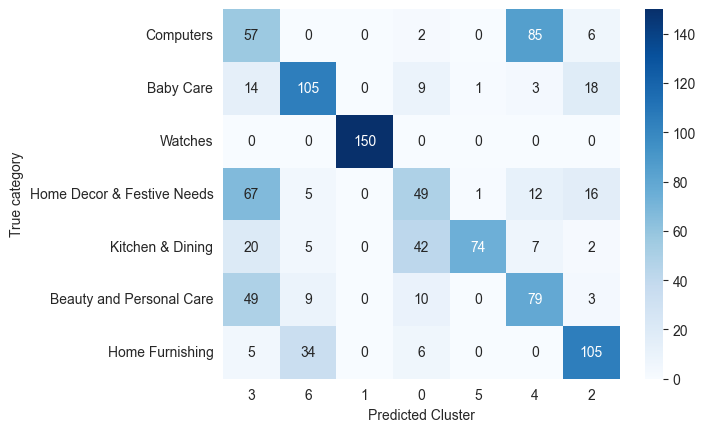

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
0,Bow,0.4033,0.45,0.27 / 0.38,0.66 / 0.70,1.00 / 1.00,0.42 / 0.33,0.97 / 0.49,0.42 / 0.53,0.70 / 0.70


In [15]:
# Matrice de confusion avec correspondance des catégories / clusters
cm = reordered_confusion_matrix(y_cat_num, labels, l_cat)
eval_df = model_score(eval_df, 'Bow', ARI, cm, l_cat)
display(eval_df.tail(1))

### Bag-of-words avec pondération Tf-Idf

* **Création de représentations Tf-Idf**

In [16]:
# Création de représentations Tf-Idf
cvtf_transform = bow_TfIdf_vectorization(df_final, 'tokens_desc', method='tf-idf', max_df=0.95, min_df=1)

* **Classification et analyse des résultats**

**TfidfVectorizer - bag-of-words avec pondération Tf-Idf:** 

ARI :  0.5263 time :  8.0


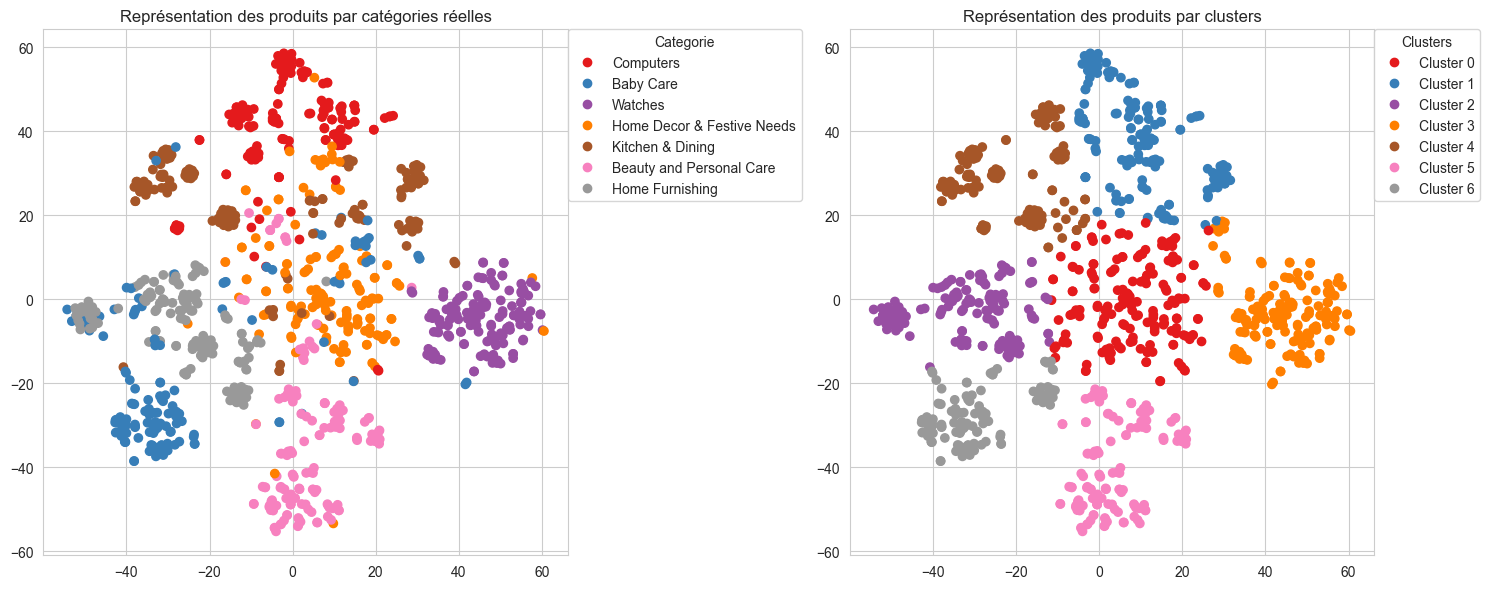

In [17]:
# Calcul de similarité Adjusted Rand Index (ARI) et visualisation du t-SNE selon les vraies catégories et selon les clusters
display(Markdown("**TfidfVectorizer - bag-of-words avec pondération Tf-Idf:** "))
ARI, X_tsne, labels =   ARI_fct(cvtf_transform, 
                                l_cat, 
                                y_cat_num, 
                                perplexity=20, 
                                init_tsne='random',
                                max_iter=1000, 
                                learning_rate=200, 
                                n_init=10, 
                                init_kmeans='k-means++',
                                random_state=42)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat, figsize=(15, 6), cmap='Set1')

La catégorie 'Watches' est également la seule qui est bien classifiée automatiquement avec cette méthode.

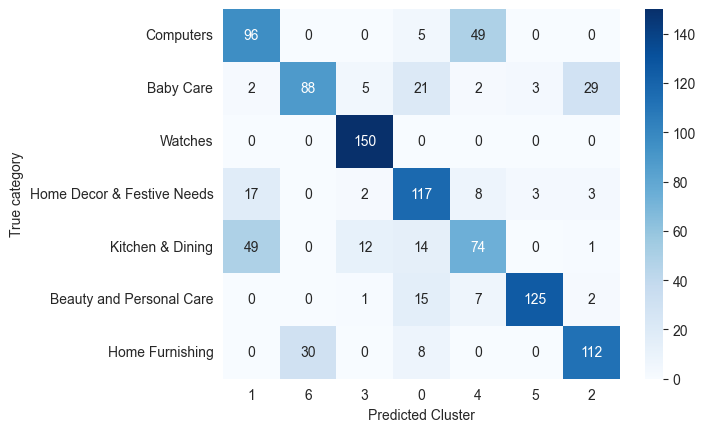

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
1,Bow Tf-Idf,0.5263,0.45,0.59 / 0.64,0.75 / 0.59,0.88 / 1.00,0.65 / 0.78,0.53 / 0.49,0.95 / 0.83,0.76 / 0.75


In [18]:
# Matrice de confusion avec correspondance des catégories / clusters
cm = reordered_confusion_matrix(y_cat_num, labels, l_cat)
eval_df = model_score(eval_df, 'Bow Tf-Idf', ARI, cm, l_cat)
display(eval_df.tail(1))

## <font color='#46abe6'>Word2Vec<a class="anchor" id="1_3"></a></font>

### Entraînement du modèle

In [19]:
# Entraînement du modèle Word2Vec
embeddings = train_word_embedding(df_final, maxlen_percentile=90)

Build & train Word2Vec model ...
Vocabulary size: 4125
Word2Vec trained
Number of unique words: 4126
Create Embedding matrix ...
Word embedding rate:  1.0
Embedding matrix: (4126, 300)
Create embedding model ...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 92, 300)        │     1,237,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,237,800 (4.72 MB)

 Trainable params: 1,237,800 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Classification

**Word2Vec:** 

ARI :  0.5693 time :  8.0


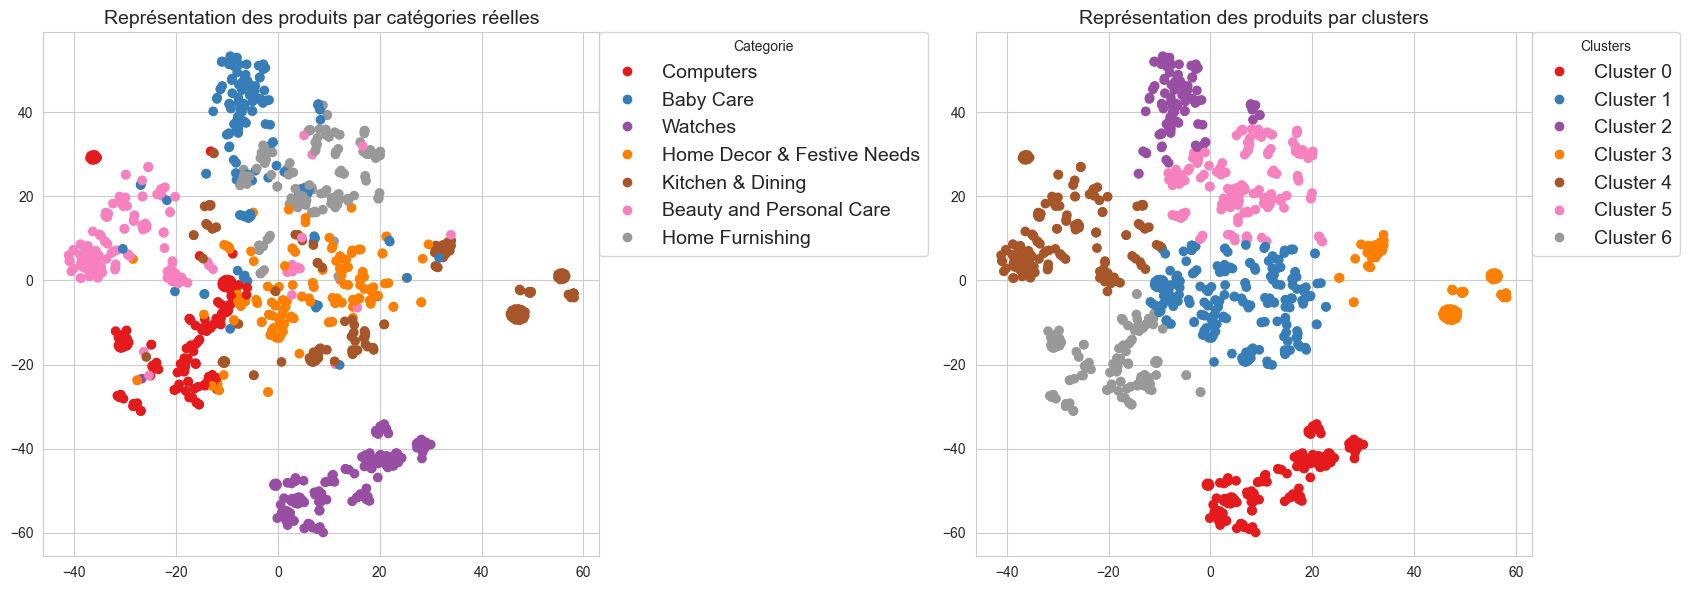

In [43]:
# Calcul de similarité Adjusted Rand Index (ARI) et visualisation du t-SNE selon les vraies catégories et selon les clusters
display(Markdown("**Word2Vec:** "))
ARI, X_tsne, labels =   ARI_fct(embeddings, 
                                l_cat, 
                                y_cat_num, 
                                perplexity=20, 
                                init_tsne='random',
                                max_iter=1000, 
                                learning_rate=200, 
                                n_init=10, 
                                init_kmeans='k-means++',
                                random_state=42)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat, figsize=(17, 6), cmap='Set1')

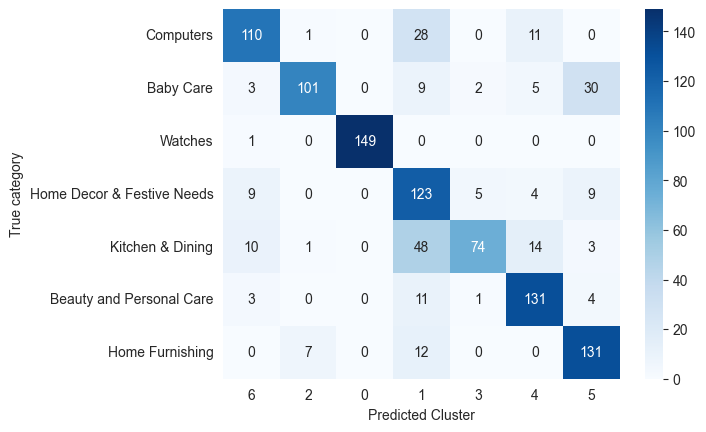

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
2,Word2Vec,0.5693,0.48,0.81 / 0.73,0.92 / 0.67,1.00 / 0.99,0.53 / 0.82,0.90 / 0.49,0.79 / 0.87,0.74 / 0.87


In [21]:
# Matrice de confusion avec correspondance des catégories / clusters
cm = reordered_confusion_matrix(y_cat_num, labels, l_cat)
eval_df = model_score(eval_df, 'Word2Vec', ARI, cm, l_cat)
display(eval_df.tail(1))

### Analyse de la classification des sous-catégories

In [22]:
# Analyse des sous-catégories
df_w2v =df_final.copy()
df_w2v.loc[:,'cluster'] = labels

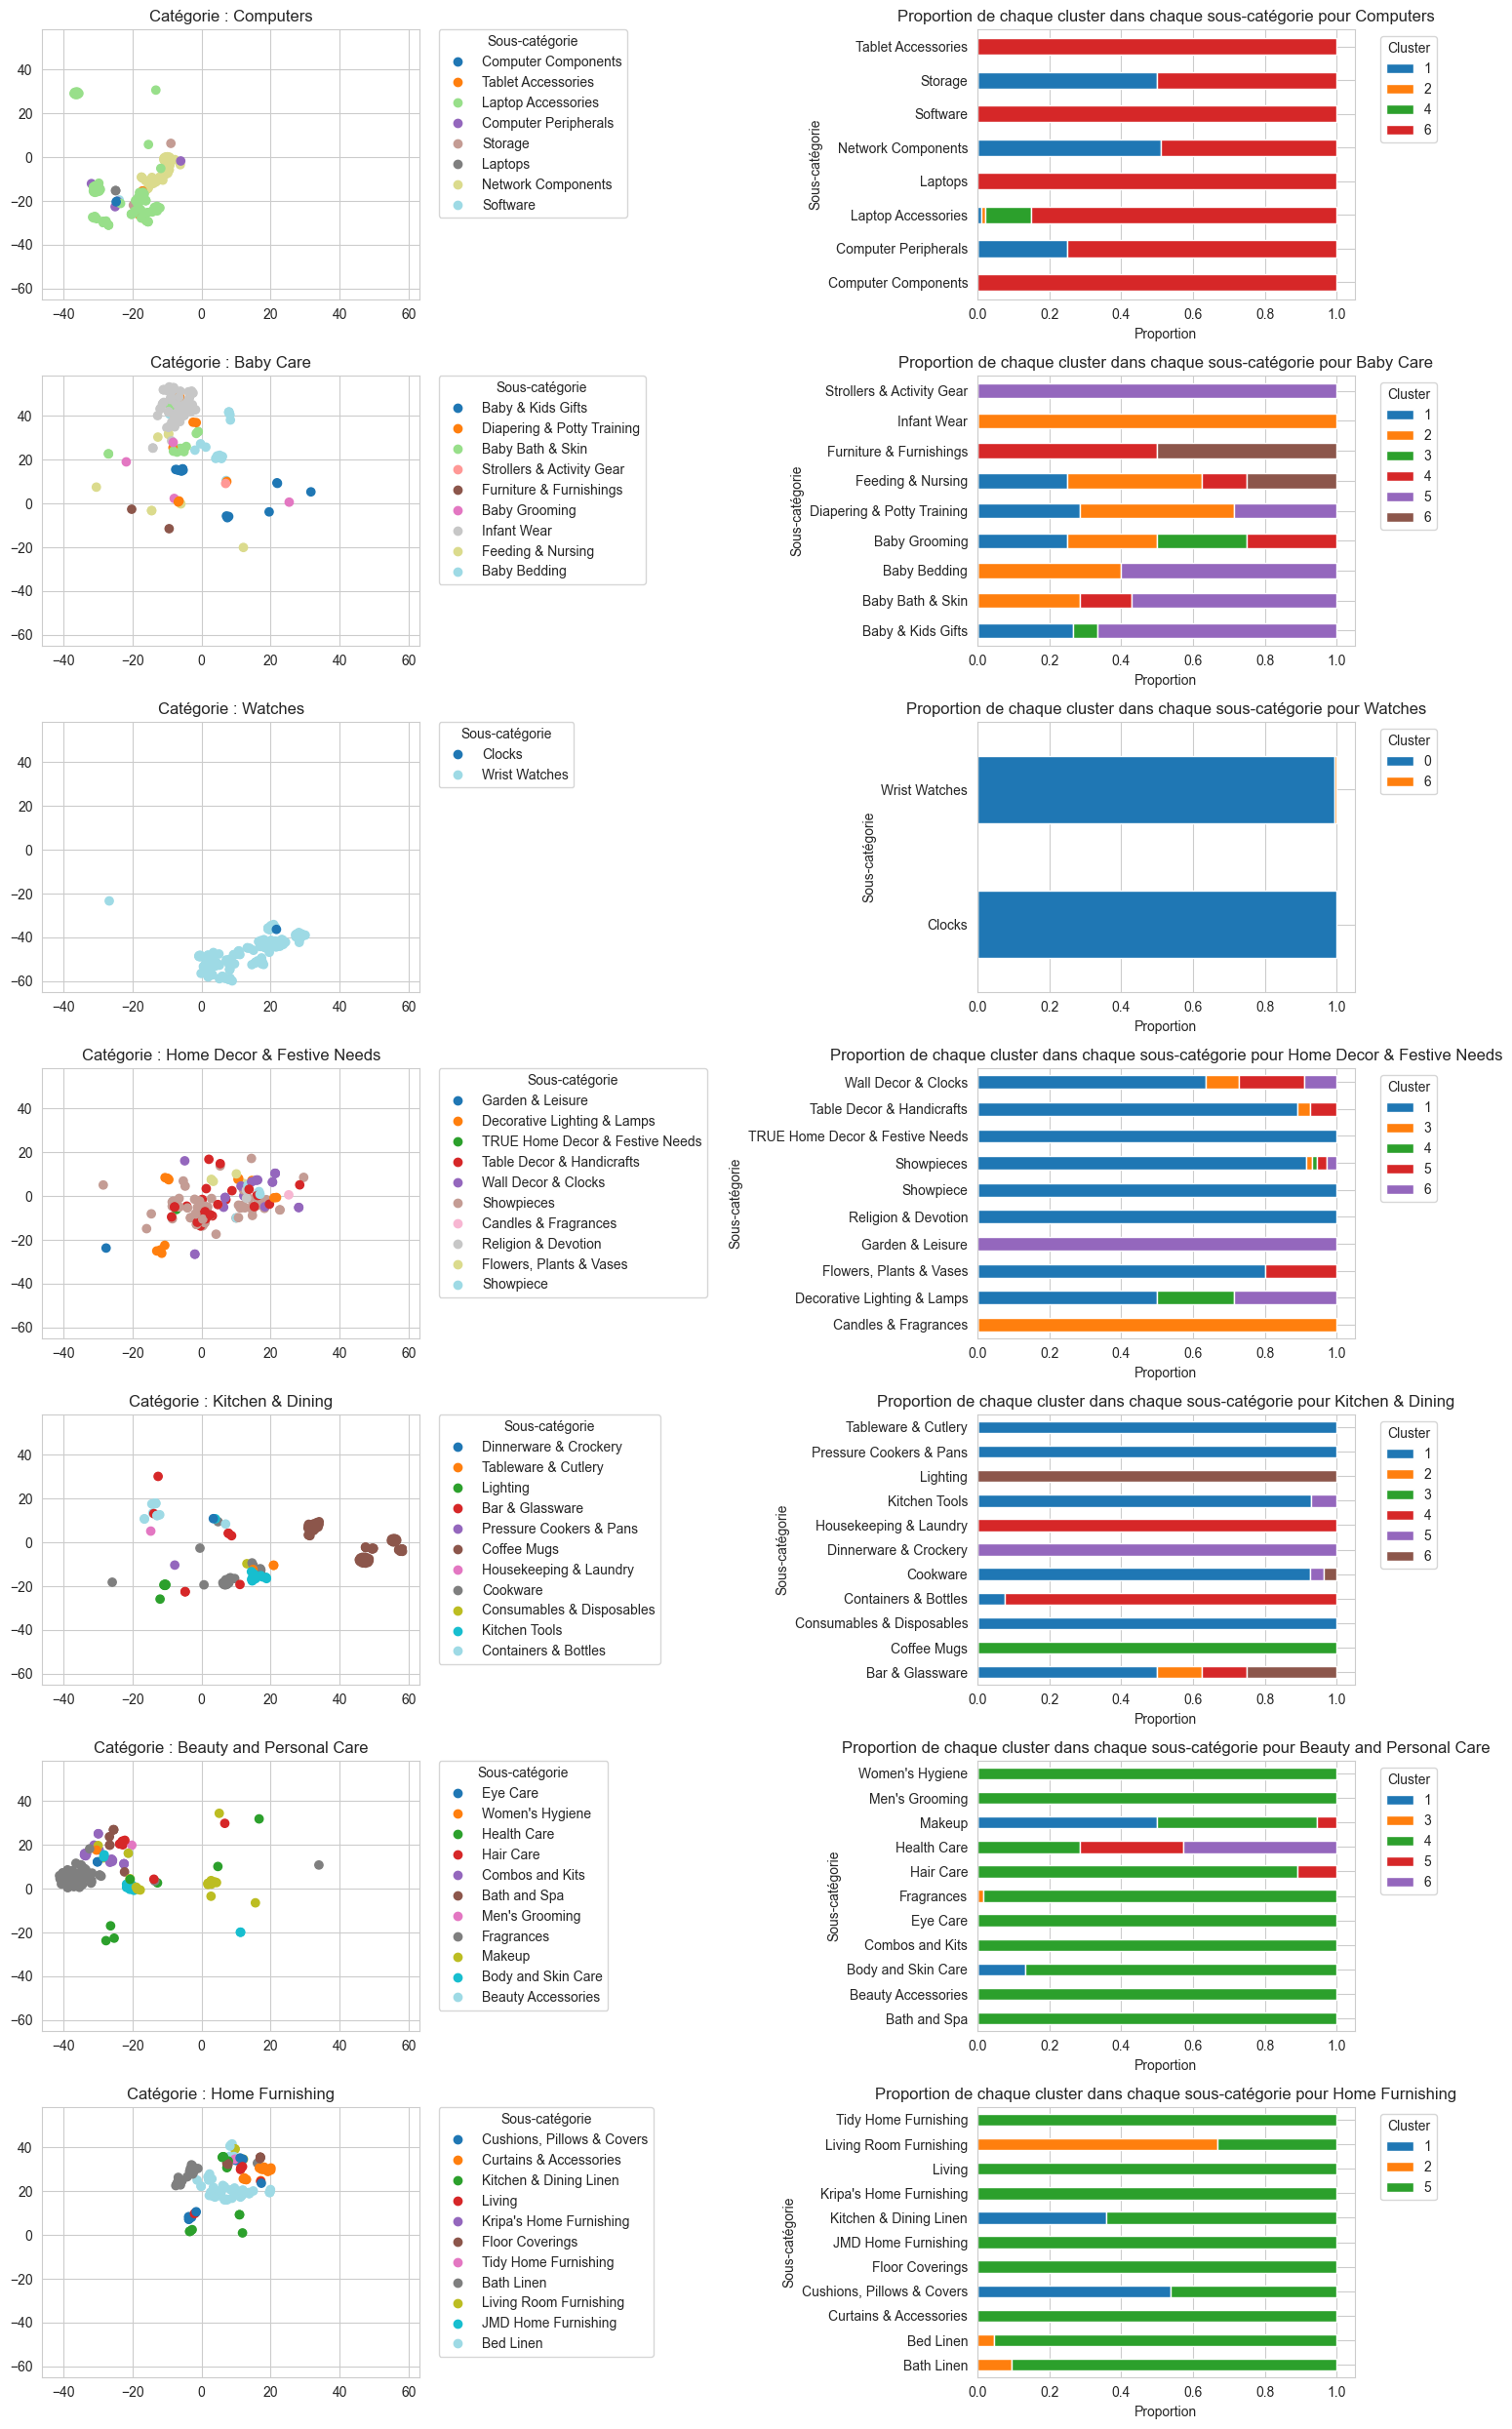

In [23]:
# Projection t-SNE des sous-catégories et répartition par cluster
TSNE_visu_subcat_fct(X_tsne,
                     y_cat_num,
                     y_subcat_num_by_category, 
                     subcategories_by_category, 
                     l_cat,
                     df_w2v,
                     figsize=(15, 25), 
                     cmap='tab20')

* Watches
* Beauty and personal Care : Fragances
* Baby Care : infant wear
* Kitchen & dining : coffee Mugs
* Computers : Network components

## <font color='#46abe6'>BERT<a class="anchor" id="1_4"></a></font>

### BERT HuggingFace - 'bert-base-uncased'

In [24]:
# Importation des résultats du 
with open('features_bert.pkl', 'rb') as file:
    features_bert = pickle.load(file)

ARI :  0.3627 time :  8.0


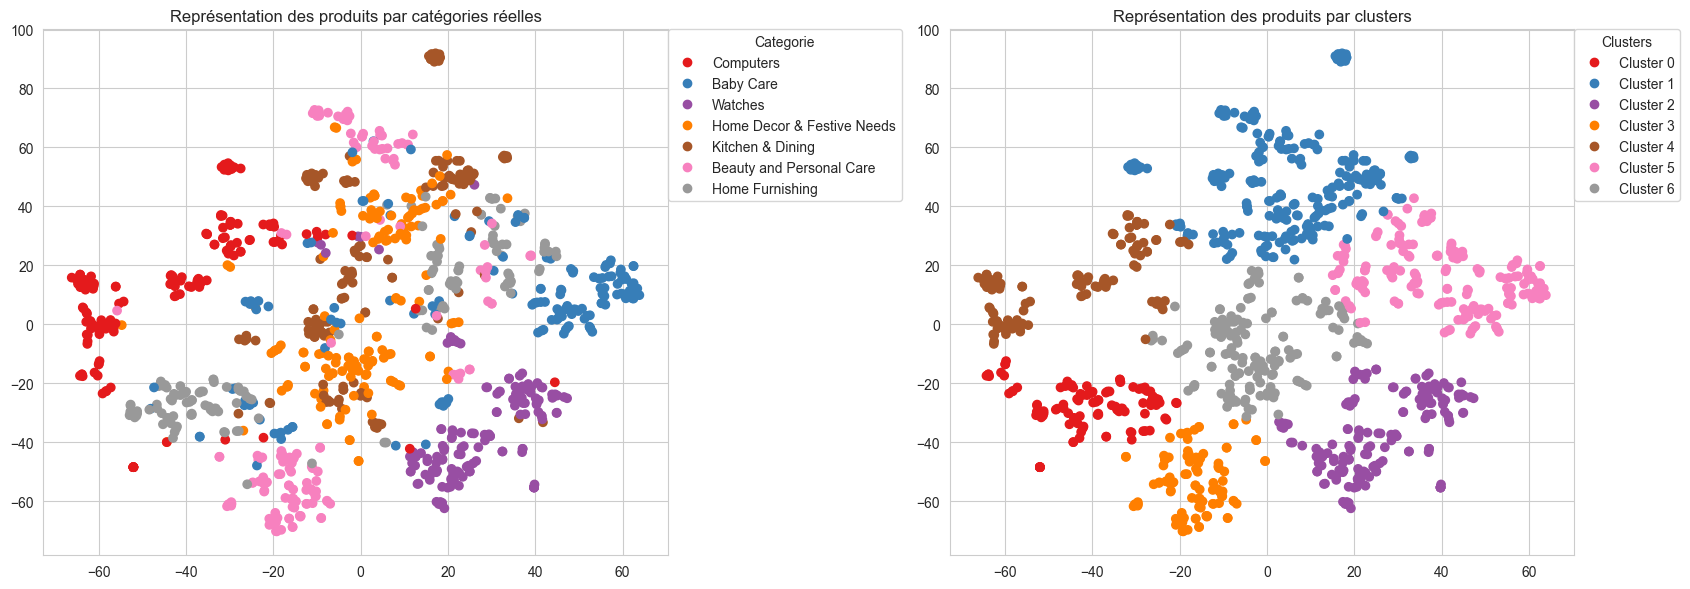

In [25]:
ARI, X_tsne, labels =   ARI_fct(features_bert, 
                                l_cat, 
                                y_cat_num, 
                                perplexity=10, 
                                init_tsne='random',
                                max_iter=1000, 
                                learning_rate=100, 
                                n_init=10, 
                                init_kmeans='k-means++',
                                random_state=42)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat, figsize=(17, 6), cmap='Set1')

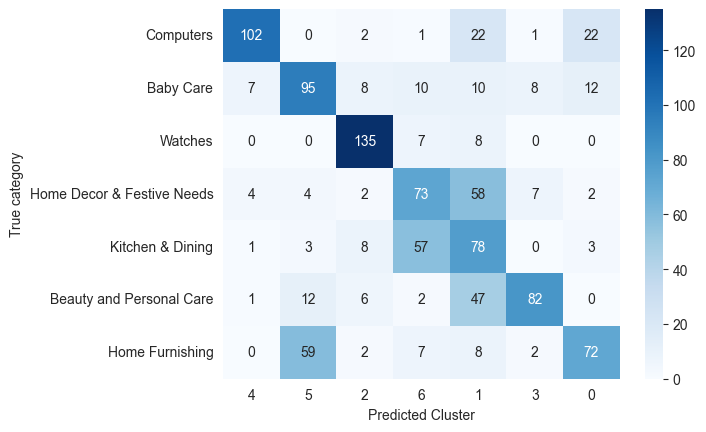

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
3,bert-base-uncased,0.3627,0.44,0.89 / 0.68,0.55 / 0.63,0.83 / 0.90,0.46 / 0.49,0.34 / 0.52,0.82 / 0.55,0.65 / 0.48


In [26]:
# Matrice de confusion avec correspondance des catégories / clusters
cm = reordered_confusion_matrix(y_cat_num, labels, l_cat)
eval_df = model_score(eval_df, 'bert-base-uncased', ARI, cm, l_cat)
display(eval_df.tail(1))

### BERT Hub Tensorflow

In [27]:
# Importation des résultats du BERT hub tensorflow
with open('features_bert_hub.pkl', 'rb') as file:
    features_bert_hub = pickle.load(file)

ARI :  0.3885 time :  8.0


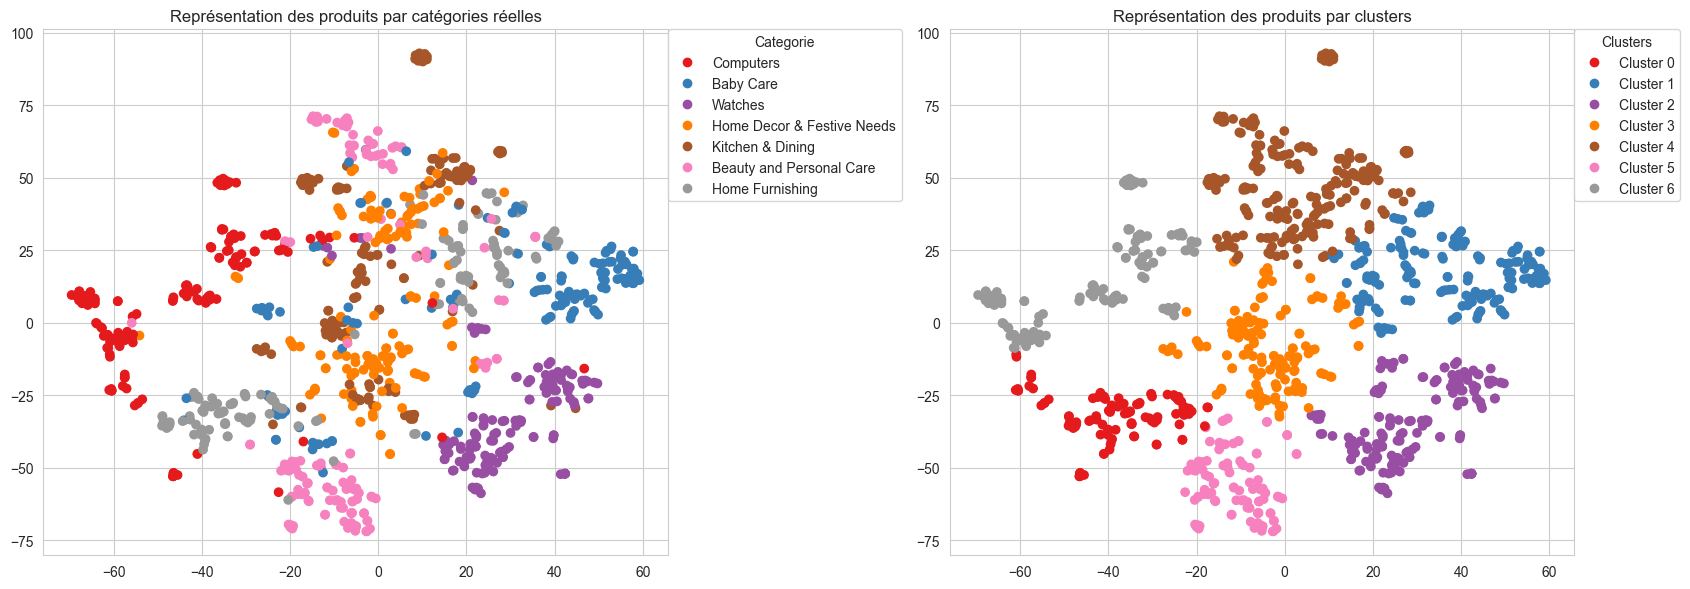

In [28]:
ARI, X_tsne, labels =   ARI_fct(features_bert_hub, 
                                l_cat, 
                                y_cat_num, 
                                perplexity=10, 
                                init_tsne='random',
                                max_iter=1000, 
                                learning_rate=100, 
                                n_init=10, 
                                init_kmeans='k-means++',
                                random_state=42)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat, figsize=(17, 6), cmap='Set1')

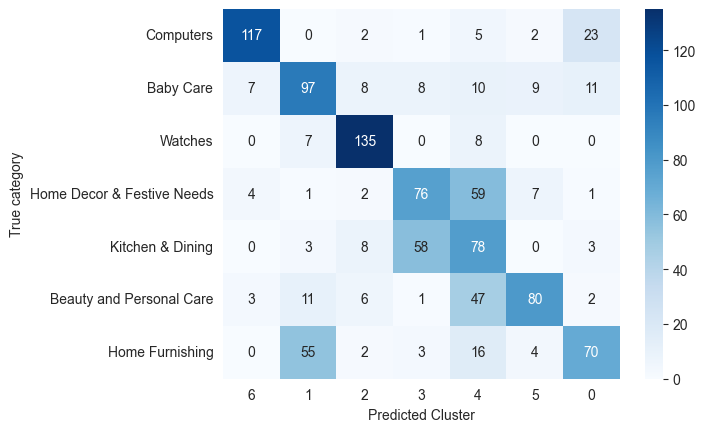

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
4,TFhub_bert-base-uncased,0.3885,0.44,0.89 / 0.78,0.56 / 0.65,0.83 / 0.90,0.52 / 0.51,0.35 / 0.52,0.78 / 0.53,0.64 / 0.47


In [29]:
# Matrice de confusion avec correspondance des catégories / clusters
cm = reordered_confusion_matrix(y_cat_num, labels, l_cat)
eval_df = model_score(eval_df, 'TFhub_bert-base-uncased', ARI, cm, l_cat)
display(eval_df.tail(1))

## <font color='#46abe6'>USE<a class="anchor" id="1_5"></a></font>

In [30]:
# Importation des résultats du USE
with open('features_USE.pkl', 'rb') as file:
    features_USE = pickle.load(file)

ARI :  0.4561 time :  8.0


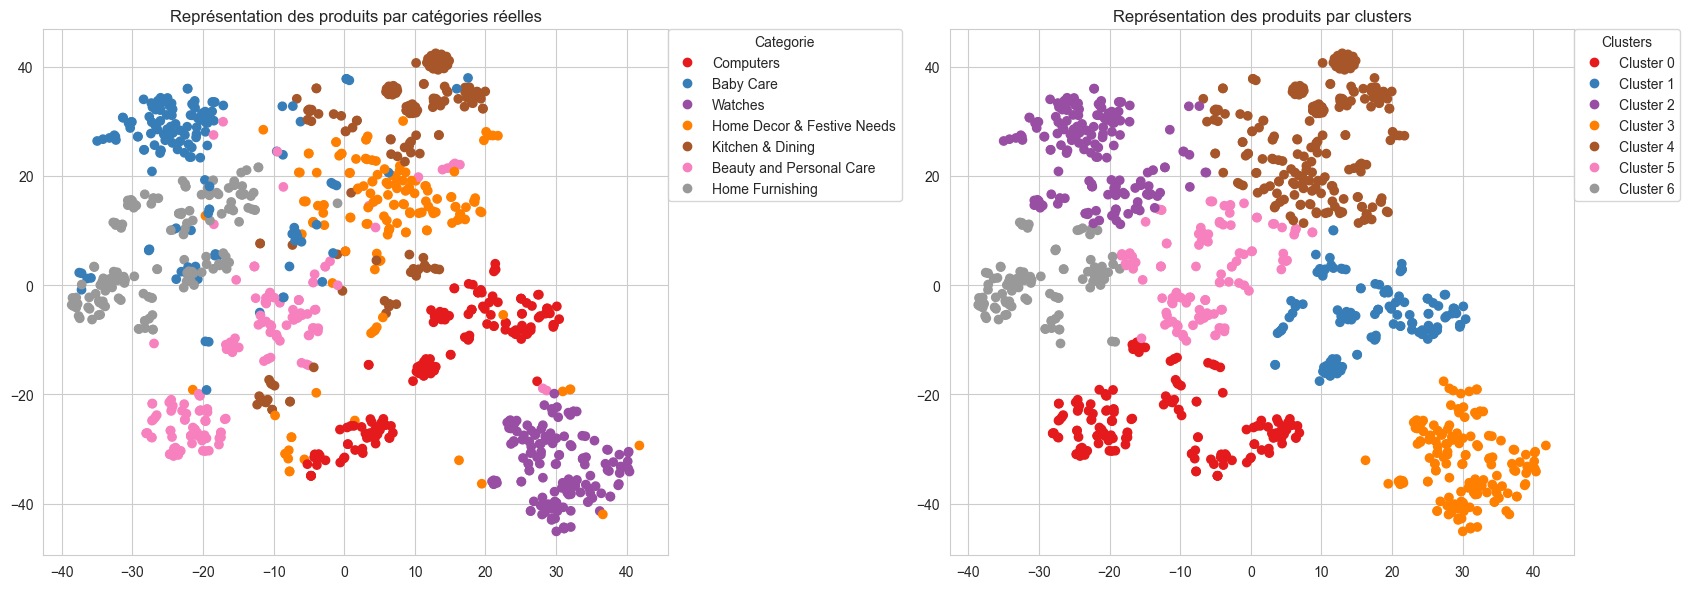

In [31]:
ARI, X_tsne, labels =   ARI_fct(features_USE, 
                                l_cat, 
                                y_cat_num, 
                                perplexity=30, 
                                init_tsne='random',
                                max_iter=1000, 
                                learning_rate=100, 
                                n_init=10, 
                                init_kmeans='k-means++',
                                random_state=42)

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat, figsize=(17, 6), cmap='Set1')

In [32]:
from sklearn.metrics import silhouette_score
silhouette_score(X_tsne, labels)

0.48543882

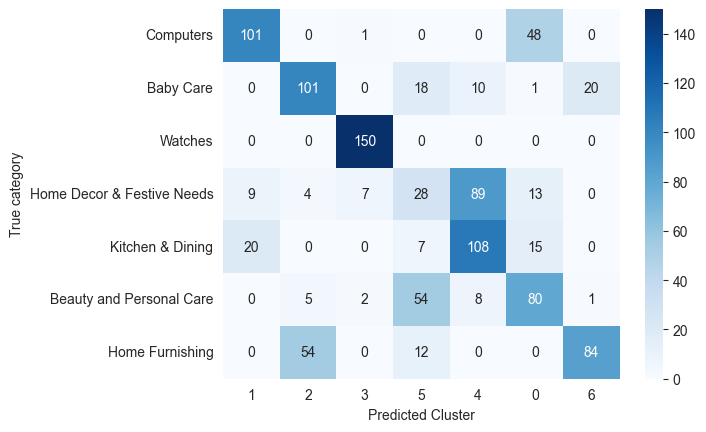

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
5,USE,0.4561,0.49,0.78 / 0.67,0.62 / 0.67,0.94 / 1.00,0.24 / 0.19,0.50 / 0.72,0.51 / 0.53,0.80 / 0.56


In [33]:
# Matrice de confusion avec correspondance des catégories / clusters
cm = reordered_confusion_matrix(y_cat_num, labels, l_cat)
eval_df = model_score(eval_df, 'USE', ARI, cm, l_cat)
display(eval_df.tail(1))

# <font color='#0a389f'>Conclusion et Perspectives<a class="anchor" id="2"></a></font>

In [34]:
display(eval_df)

,Model,ARI,silhouette_score,Precision / recall - Computers,Precision / recall - Baby Care,Precision / recall - Watches,Precision / recall - Home Decor & Festive Needs,Precision / recall - Kitchen & Dining,Precision / recall - Beauty and Personal Care,Precision / recall - Home Furnishing
0,Bow,0.4033,0.45,0.27 / 0.38,0.66 / 0.70,1.00 / 1.00,0.42 / 0.33,0.97 / 0.49,0.42 / 0.53,0.70 / 0.70
1,Bow Tf-Idf,0.5263,0.45,0.59 / 0.64,0.75 / 0.59,0.88 / 1.00,0.65 / 0.78,0.53 / 0.49,0.95 / 0.83,0.76 / 0.75
2,Word2Vec,0.5693,0.48,0.81 / 0.73,0.92 / 0.67,1.00 / 0.99,0.53 / 0.82,0.90 / 0.49,0.79 / 0.87,0.74 / 0.87
3,bert-base-uncased,0.3627,0.44,0.89 / 0.68,0.55 / 0.63,0.83 / 0.90,0.46 / 0.49,0.34 / 0.52,0.82 / 0.55,0.65 / 0.48
4,TFhub_bert-base-uncased,0.3885,0.44,0.89 / 0.78,0.56 / 0.65,0.83 / 0.90,0.52 / 0.51,0.35 / 0.52,0.78 / 0.53,0.64 / 0.47
5,USE,0.4561,0.49,0.78 / 0.67,0.62 / 0.67,0.94 / 1.00,0.24 / 0.19,0.50 / 0.72,0.51 / 0.53,0.80 / 0.56


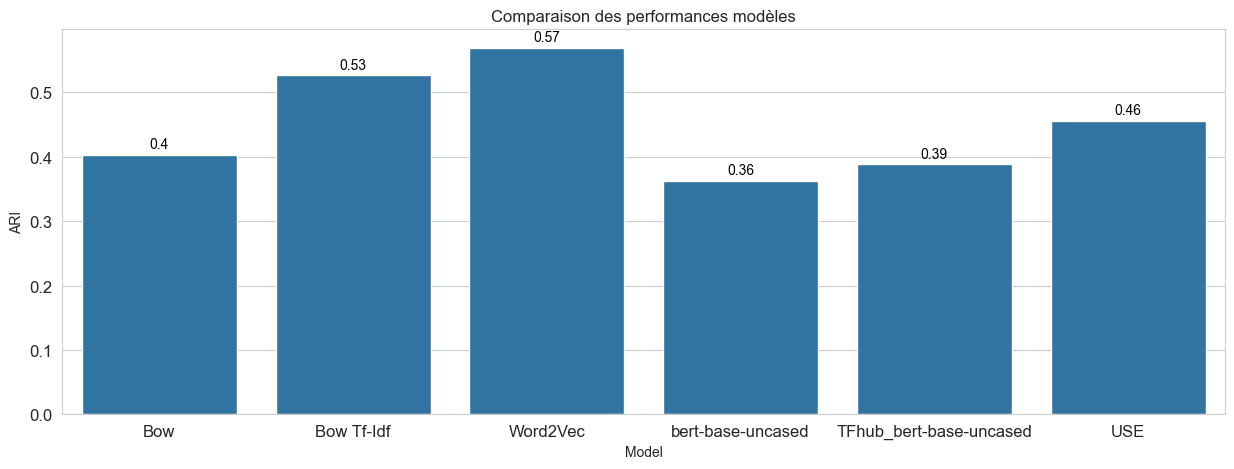

In [40]:
# Représentation des résultats 
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax = sns.barplot(data=eval_df, x='Model', y='ARI')
# Afficher l'ARI au-dessus des barres
for index, row in eval_df.iterrows():
    ax.text(index, row['ARI'] + 0.01, round(row['ARI'], 2), color='black', ha="center")
ax.set_title('Comparaison des performances modèles')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.show()

Il n'y a pas un modéle qui soit performant sur toutes les catégories. Les meilleurs modèles ont un ARI score de ~0.5.
Certains modèles sont très performants sur une catégorie :
- USE : computers
- Bag-of-words : Watches
- BOW Tf-Idf : Beauty and Personal Care


* Computers : USE
* Home Furnishing : Word2Vec
* Home Decor & festives Needs : USE
* Watches : Bag-of-Words
* Baby Care : Word2Vec
* Beauty and Personal Care : BOW Tf-Idf
* Kitchen & Dining : Bag-of-words pour une sous-catégorie


**Perspectives**:
* Avoir un système de vote avec plusieurs modèles 
* Utiliser les features des 2 modèles 
* Utiliser "Product name" 
* Extraire les features des images et étudier la faisabilité de classifier les articles 